In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout
from keras import regularizers

import warnings
warnings.filterwarnings('ignore') 

In [7]:
df = pd.read_csv('/content/heart.csv')

In [8]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


EDA

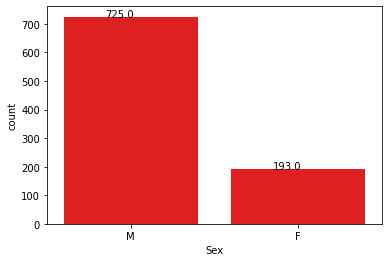

In [10]:
ax = sns.countplot(x="Sex", data=df,color='red')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

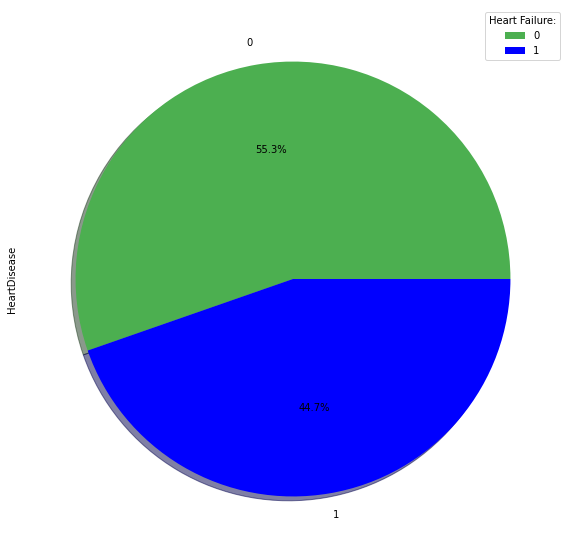

In [11]:
plt.figure(1, figsize=(10,10))
df['HeartDisease'].value_counts().plot.pie(autopct="%1.1f%%",colors = ( "#4CAF50", "blue"),labels = df['HeartDisease'].unique(), shadow = True)
plt.legend(title = "Heart Failure:")
plt.show()

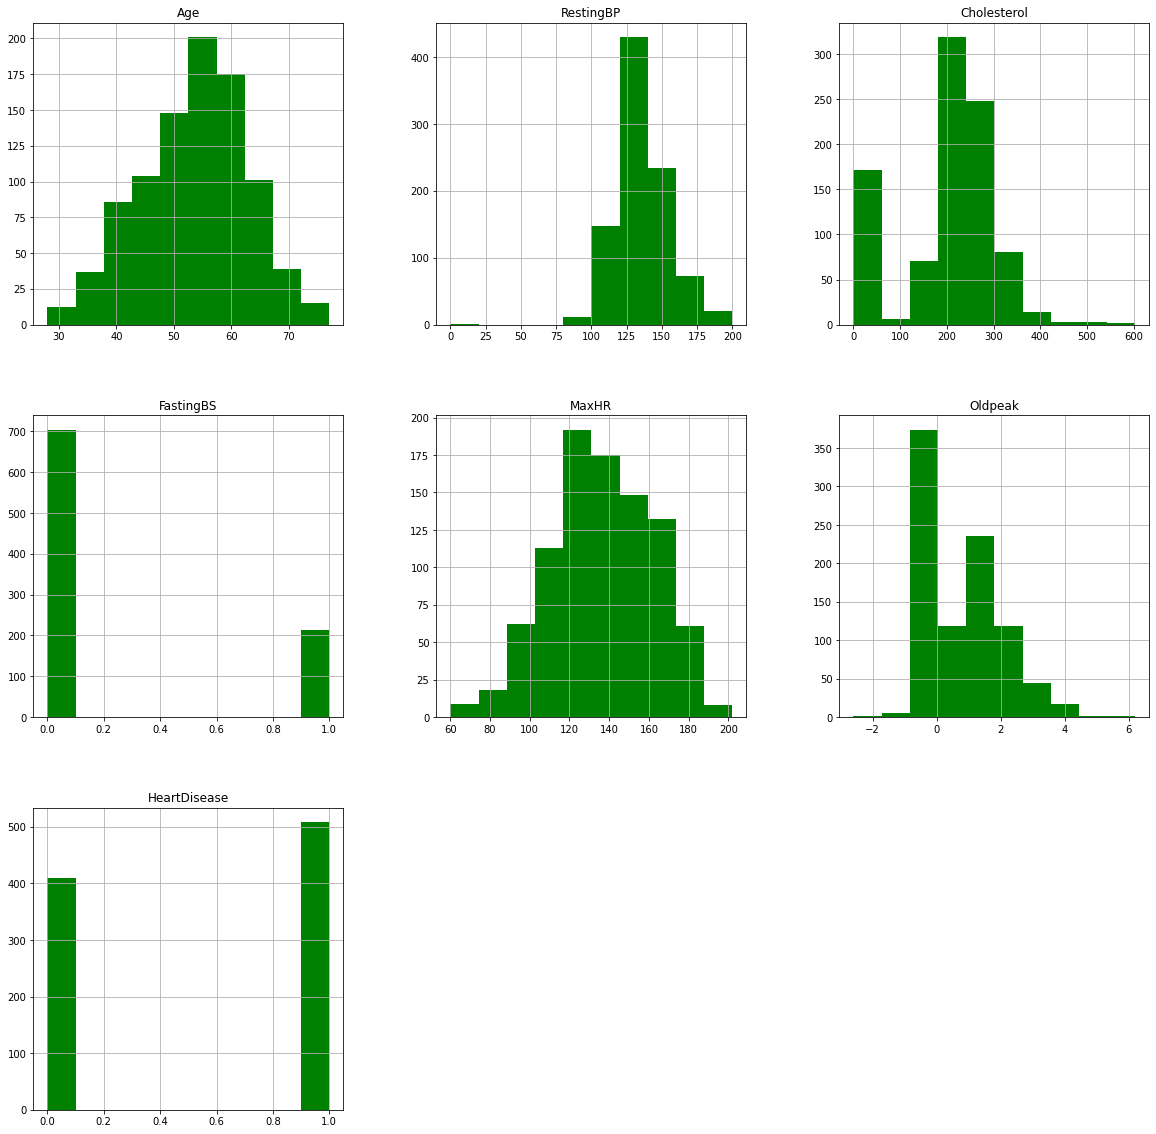

In [12]:
# plot histograms for each numerical variable
df.hist(figsize = (20, 20),color='green')
plt.show()

In [13]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()

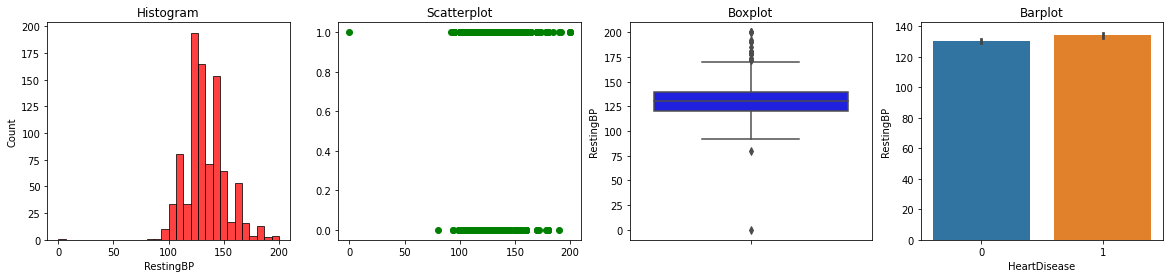

In [14]:
diagnostic_plots(df,'RestingBP','HeartDisease')

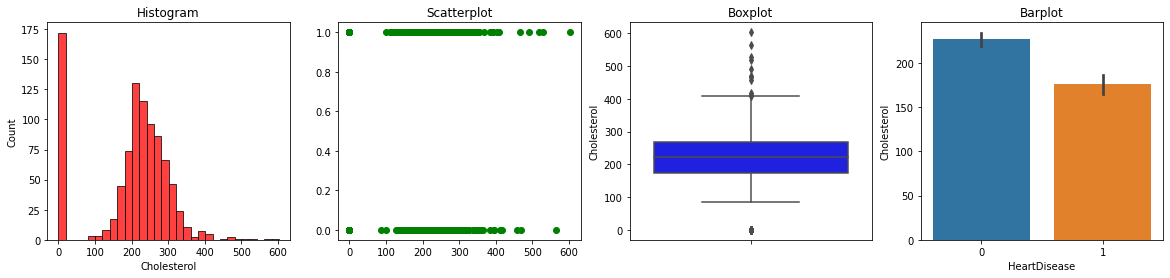

In [15]:
diagnostic_plots(df,'Cholesterol','HeartDisease')

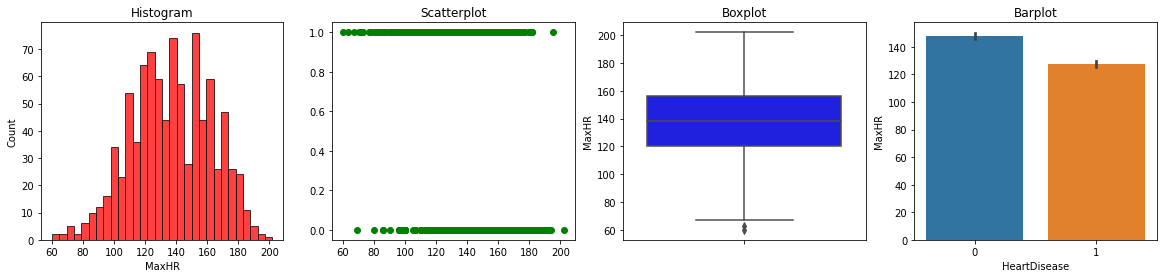

In [16]:
diagnostic_plots(df,'MaxHR','HeartDisease')

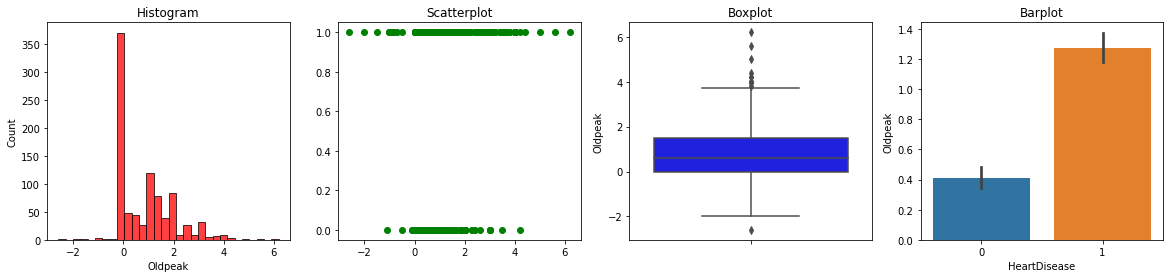

In [17]:
diagnostic_plots(df,'Oldpeak','HeartDisease')

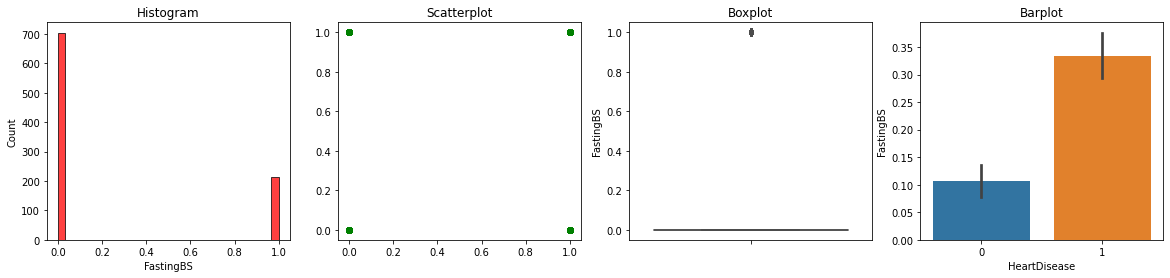

In [18]:
diagnostic_plots(df,'FastingBS','HeartDisease')

In [19]:
# We have only 0's and 1's in this feature.
df.FastingBS.value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

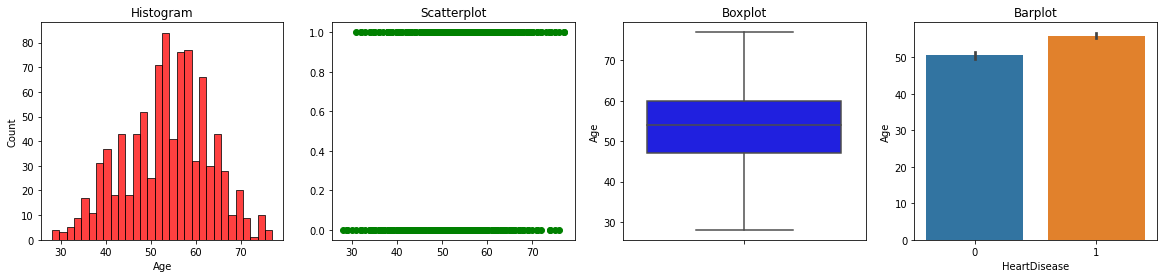

In [20]:
diagnostic_plots(df,'Age','HeartDisease')

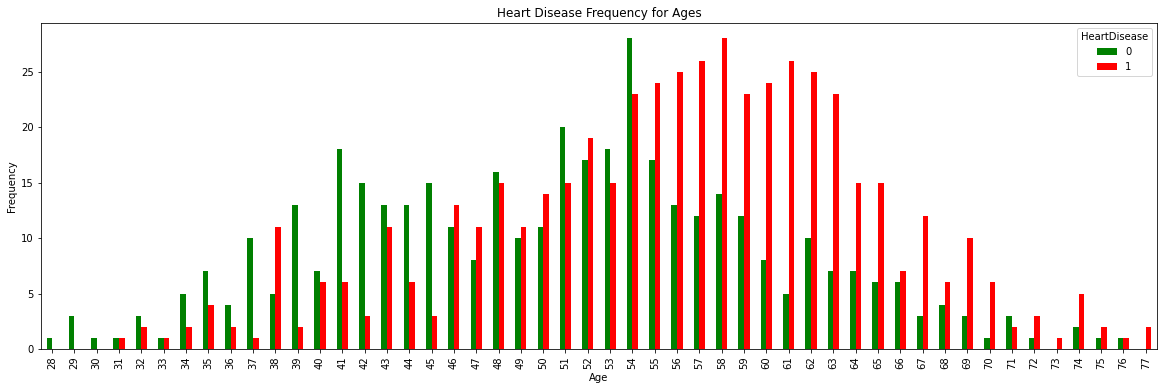

In [21]:
pd.crosstab(df.Age,df.HeartDisease).plot(kind="bar",figsize=(20,6),color= ['green','red'])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

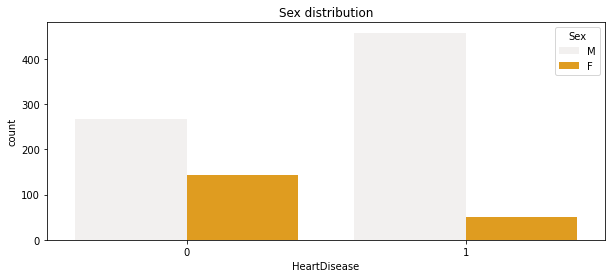

In [22]:
plt.figure(figsize=(10,4))
g = sns.countplot(data=df, x='HeartDisease', hue='Sex',color='orange')
plt.title('Sex distribution')
plt.show()

In [23]:
def detect_outliers(df,features):
    df_copy = df.drop(df[(df[features] == 0)].index)
    # 1st quartile
    q1 = df_copy[features].quantile(0.25)
    # 3rd quartile
    q3 = df_copy[features].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    outlier_list_col = df_copy[(df_copy[features] >= Upper_tail) | (df_copy[features] <= Lower_tail)]  # | means "or"
    return pd.DataFrame(outlier_list_col)

In [24]:
RestingBP_outlier = detect_outliers(df,'RestingBP')
RestingBP_outlier.value_counts(RestingBP_outlier['HeartDisease'])

HeartDisease
1    28
0    13
dtype: int64

In [25]:
Cholesterol_outlier = detect_outliers(df,'Cholesterol')
Cholesterol_outlier.value_counts(Cholesterol_outlier['HeartDisease'])

HeartDisease
1    13
0    10
dtype: int64

In [26]:
imputer = SimpleImputer(strategy='median')

# We fit the imputer to the train set.
# The imputer will learn the median of all variables.
cols_to_use = ['Cholesterol','RestingBP']
imputer.fit(df[cols_to_use])

SimpleImputer(strategy='median')

In [27]:
df[cols_to_use] = imputer.transform(df[cols_to_use])

In [28]:
df.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [29]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [30]:
df['AgeGroup']= np.nan
df.loc[(df['Age']>=28) & (df['Age']<35),'AgeGroup']='Young Adult' 
df.loc[(df['Age']>=35) & (df['Age']<=64),'AgeGroup']='Adult'
df.loc[df['Age']>64,'AgeGroup']='Seniors'

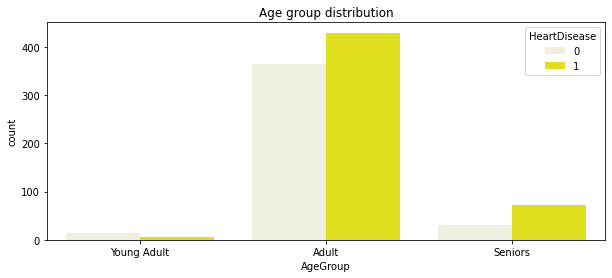

In [31]:
plt.figure(figsize=(10,4))
g=sns.countplot(data=df, x='AgeGroup', hue='HeartDisease', order=['Young Adult','Adult','Seniors'],color='yellow')
plt.title('Age group distribution')
plt.show()

In [32]:
df.drop(['Age'], axis=1, inplace=True)

In [33]:
catcols = ['Sex', 'ChestPainType','FastingBS','RestingECG',
            'ExerciseAngina',  'ST_Slope','AgeGroup']

In [34]:
def Label_Encoding(df,feature):
    label_encoder = LabelEncoder()
    df[feature]= label_encoder.fit_transform(df[feature])

In [35]:
for i in catcols:
    Label_Encoding(df,i)

In [36]:
df.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup
0,1,1,140.0,289.0,0,1,172,0,0.0,2,0,0
1,0,2,160.0,180.0,0,1,156,0,1.0,1,1,0
2,1,1,130.0,283.0,0,2,98,0,0.0,2,0,0
3,0,0,138.0,214.0,0,1,108,1,1.5,1,1,0
4,1,2,150.0,195.0,0,1,122,0,0.0,2,0,0


In [37]:
numcols  = ['RestingBP','Cholesterol','MaxHR']

In [38]:
scaler = StandardScaler()

# Scale data
df[numcols] = scaler.fit_transform(df[numcols])

Train test split

In [39]:
# Set up X and y variables
y, X = df['HeartDisease'], df.drop(columns='HeartDisease')

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

PREDICTION

In [40]:
logreg = LogisticRegression()

In [41]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [42]:
y_pred = logreg.predict(X_test)

In [43]:
logregAcc = accuracy_score(y_test,y_pred)
logregAcc

0.8659420289855072

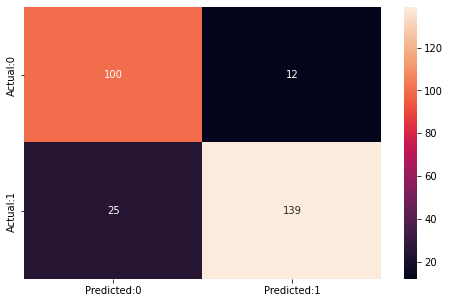

In [44]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

KNN

In [45]:
# Building a model using KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [46]:
y_pred = knn.predict(X_test)

In [47]:
knnAcc = accuracy_score(y_test,y_pred)
knnAcc

0.8659420289855072

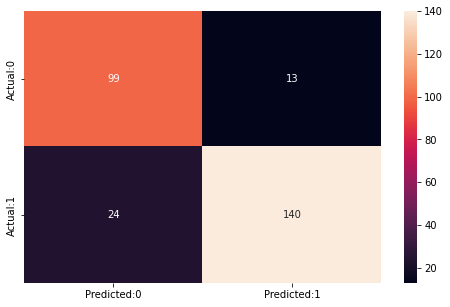

In [48]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

Decision Tree

In [49]:
# Building Decision Tree model 
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [50]:
y_pred = clf.predict(X_test)

In [51]:
clfAcc = accuracy_score(y_test,y_pred)
clfAcc

0.7717391304347826

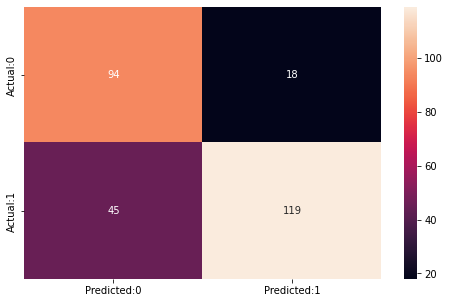

In [52]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

SVM

In [53]:
svm = SVC(random_state=1)
svm.fit(X_train,y_train)

SVC(random_state=1)

In [54]:
y_pred = svm.predict(X_test)

In [55]:
svmAcc = accuracy_score(y_test,y_pred)
svmAcc

0.8840579710144928

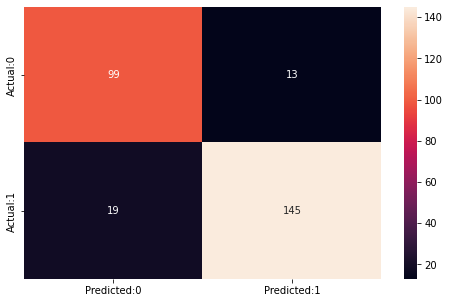

In [56]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

In [57]:
data={'Estimators':['Logistic Regression', 'K-Nearest Neighbor', 'Decision Tree','Support Vector Machine'],
      'Accuracy':[logregAcc,knnAcc,clfAcc,svmAcc]}

data =pd.DataFrame(data)

data.sort_values('Accuracy', ascending=False)

,Estimators,Accuracy
3,Support Vector Machine,0.884058
0,Logistic Regression,0.865942
1,K-Nearest Neighbor,0.865942
2,Decision Tree,0.771739
